## 1. Setup: Import Libraries and Load Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.1


In [2]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Silicon GPU (MPS)


In [3]:
# Load test data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Test set size: {len(test_dataset)}")

Test set size: 10000


## 2. Load the Trained Model

In [4]:
# Define model architecture (same as before)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load trained model
model = SimpleNN().to(device)
model.load_state_dict(torch.load('../models/mnist_model.pth'))
model.eval()

print("Trained model loaded successfully!")

Trained model loaded successfully!


## 3. Generate Predictions on Entire Test Set

Let's run the model on all test samples and collect predictions.

In [5]:
# Collect all predictions and true labels
all_predictions = []
all_labels = []
all_probabilities = []

print("Evaluating model on test set...")

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        probabilities = F.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

print(f"Evaluated {len(all_predictions)} test samples")

Evaluating model on test set...
Evaluated 10000 test samples


## 4. Calculate Overall Accuracy

In [6]:
# Overall accuracy
correct = (all_predictions == all_labels).sum()
total = len(all_labels)
accuracy = 100.0 * correct / total

print(f"Overall Test Accuracy: {accuracy:.2f}%")
print(f"Correct predictions: {correct}/{total}")
print(f"Incorrect predictions: {total - correct}/{total}")

Overall Test Accuracy: 97.64%
Correct predictions: 9764/10000
Incorrect predictions: 236/10000


## 5. Per-Class Accuracy

Let's see how well the model performs on each digit.

Per-Digit Accuracy:
Digit 0: 97.14% (952/980)
Digit 1: 98.59% (1119/1135)
Digit 2: 97.77% (1009/1032)
Digit 3: 97.92% (989/1010)
Digit 4: 97.45% (957/982)
Digit 5: 97.98% (874/892)
Digit 6: 98.75% (946/958)
Digit 7: 96.69% (994/1028)
Digit 8: 97.43% (949/974)
Digit 9: 96.63% (975/1009)


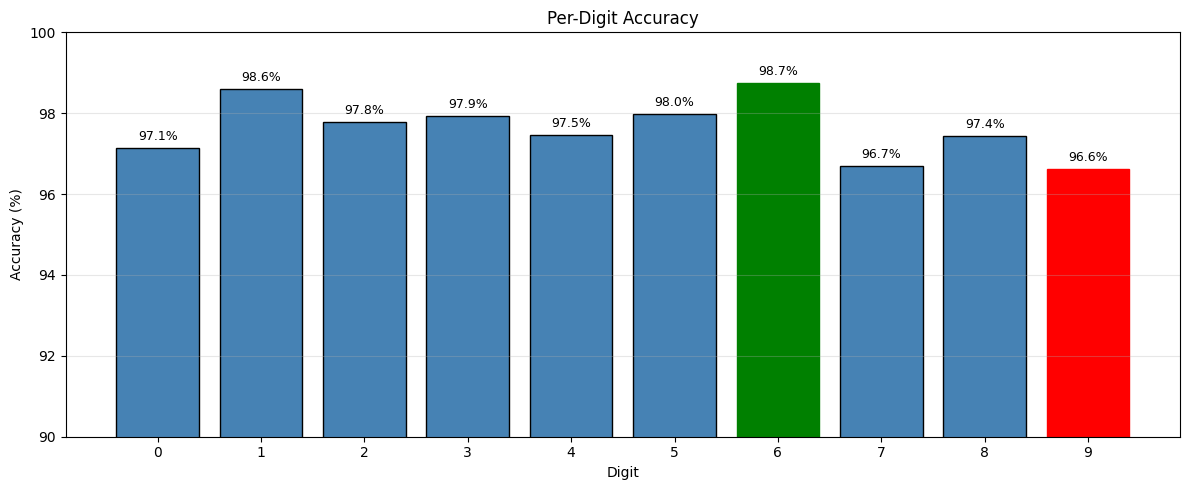


Best performance: Digit 6 (98.75%)
Worst performance: Digit 9 (96.63%)


In [7]:
# Calculate accuracy for each digit
print("Per-Digit Accuracy:")
print("=" * 50)

digit_accuracies = []

for digit in range(10):
    # Get indices for this digit
    digit_indices = all_labels == digit
    digit_preds = all_predictions[digit_indices]
    digit_true = all_labels[digit_indices]
    
    # Calculate accuracy
    digit_correct = (digit_preds == digit_true).sum()
    digit_total = len(digit_true)
    digit_acc = 100.0 * digit_correct / digit_total
    digit_accuracies.append(digit_acc)
    
    print(f"Digit {digit}: {digit_acc:.2f}% ({digit_correct}/{digit_total})")

# Visualize per-digit accuracy
plt.figure(figsize=(12, 5))
bars = plt.bar(range(10), digit_accuracies, color='steelblue', edgecolor='black')

# Color the bars - green for highest, red for lowest
max_idx = np.argmax(digit_accuracies)
min_idx = np.argmin(digit_accuracies)
bars[max_idx].set_color('green')
bars[min_idx].set_color('red')

plt.xlabel('Digit')
plt.ylabel('Accuracy (%)')
plt.title('Per-Digit Accuracy')
plt.xticks(range(10))
plt.ylim(90, 100)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, acc in enumerate(digit_accuracies):
    plt.text(i, acc + 0.2, f'{acc:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nBest performance: Digit {max_idx} ({digit_accuracies[max_idx]:.2f}%)")
print(f"Worst performance: Digit {min_idx} ({digit_accuracies[min_idx]:.2f}%)")

## 6. Confusion Matrix

A confusion matrix shows which digits get confused with which.

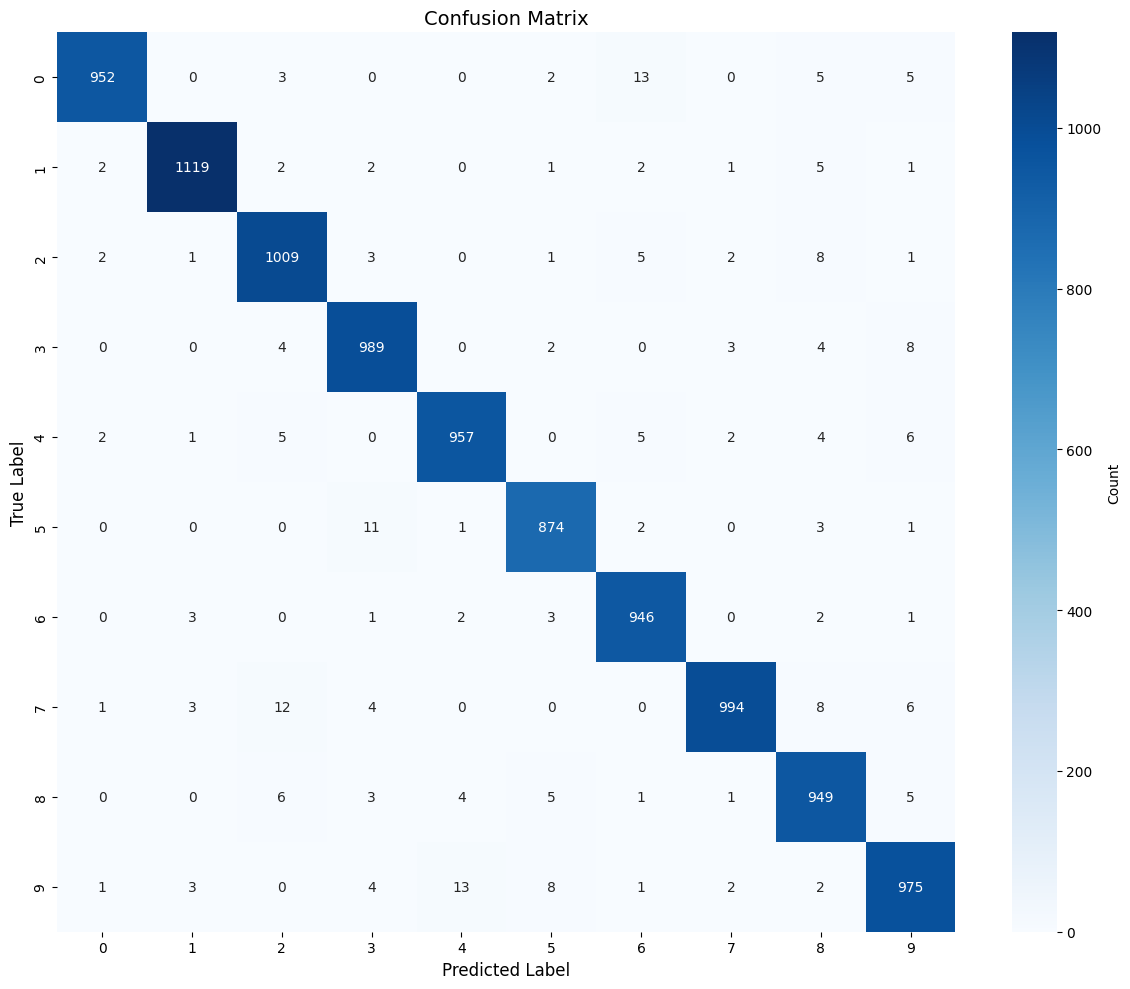


Reading the confusion matrix:
- Diagonal values (top-left to bottom-right) are correct predictions
- Off-diagonal values are misclassifications
- Row = True label, Column = Predicted label


In [8]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

print("\nReading the confusion matrix:")
print("- Diagonal values (top-left to bottom-right) are correct predictions")
print("- Off-diagonal values are misclassifications")
print("- Row = True label, Column = Predicted label")

## 7. Analyze Common Misclassifications

In [9]:
# Find most common confusions (excluding correct predictions)
print("Most Common Misclassifications:")
print("=" * 50)

confusions = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusions.append((i, j, cm[i, j]))

# Sort by count
confusions.sort(key=lambda x: x[2], reverse=True)

# Print top 10 confusions
for true_label, pred_label, count in confusions[:10]:
    print(f"{true_label} misclassified as {pred_label}: {count} times")

Most Common Misclassifications:
0 misclassified as 6: 13 times
9 misclassified as 4: 13 times
7 misclassified as 2: 12 times
5 misclassified as 3: 11 times
2 misclassified as 8: 8 times
3 misclassified as 9: 8 times
7 misclassified as 8: 8 times
9 misclassified as 5: 8 times
4 misclassified as 9: 6 times
7 misclassified as 9: 6 times


## 8. Visualize Correct Predictions

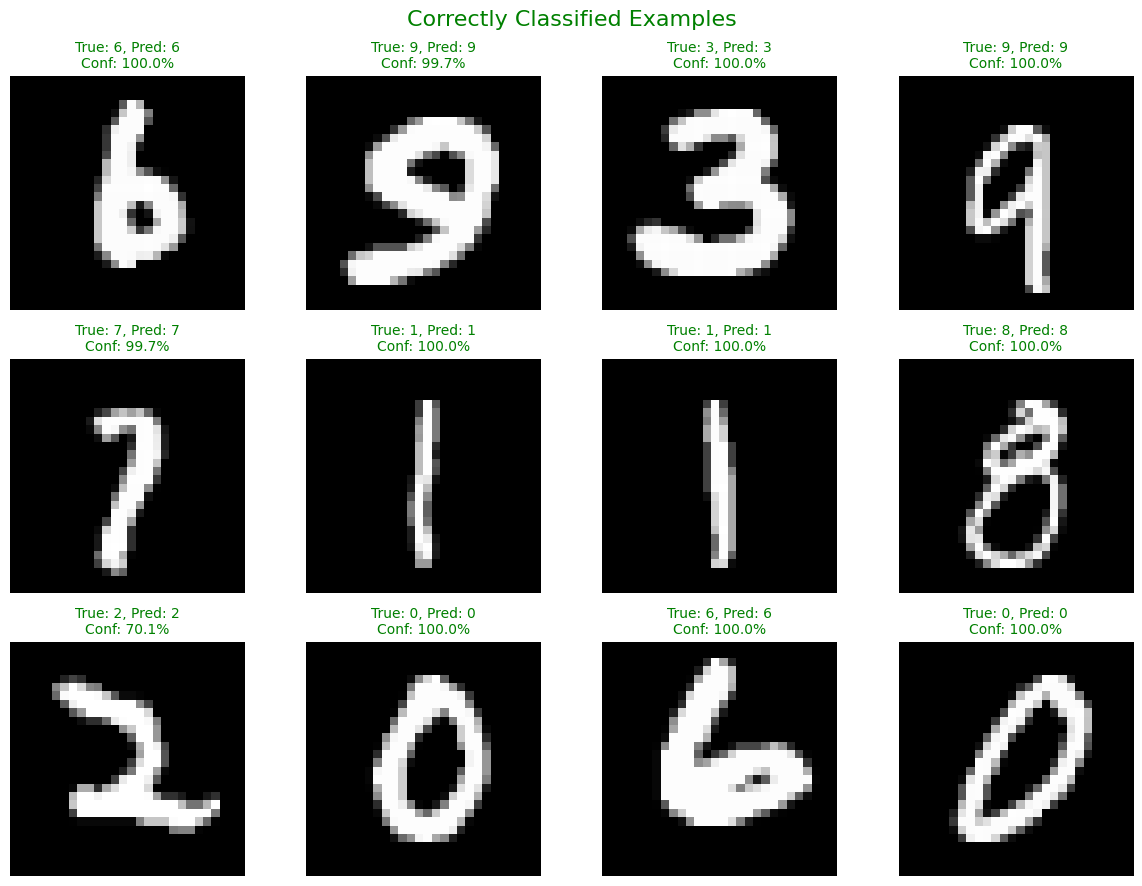

In [10]:
# Find correctly classified examples
correct_indices = np.where(all_predictions == all_labels)[0]

# Sample 12 random correct predictions
sample_correct = np.random.choice(correct_indices, 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Correctly Classified Examples', fontsize=16, color='green')

for idx, ax in enumerate(axes.flat):
    img_idx = sample_correct[idx]
    image, label = test_dataset[img_idx]
    prediction = all_predictions[img_idx]
    confidence = all_probabilities[img_idx][prediction] * 100
    
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.set_title(f'True: {label}, Pred: {prediction}\nConf: {confidence:.1f}%', 
                 color='green', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 9. Visualize Incorrect Predictions

This is where we learn the most - by looking at mistakes!

Total incorrect predictions: 236


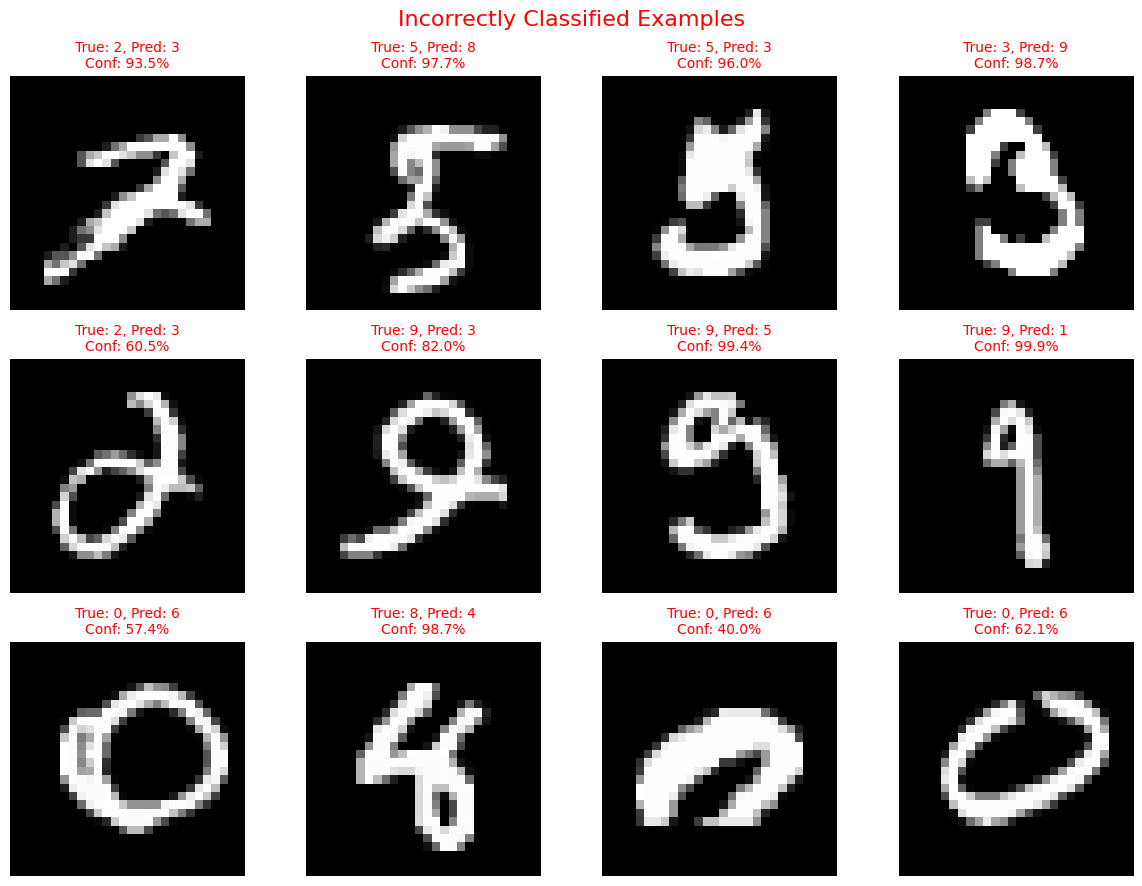


Note: Look at these mistakes carefully!
Some may be ambiguous even for humans.


In [11]:
# Find incorrectly classified examples
incorrect_indices = np.where(all_predictions != all_labels)[0]

print(f"Total incorrect predictions: {len(incorrect_indices)}")

# Sample up to 12 incorrect predictions
num_samples = min(12, len(incorrect_indices))
sample_incorrect = np.random.choice(incorrect_indices, num_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Incorrectly Classified Examples', fontsize=16, color='red')

for idx, ax in enumerate(axes.flat):
    if idx < len(sample_incorrect):
        img_idx = sample_incorrect[idx]
        image, label = test_dataset[img_idx]
        prediction = all_predictions[img_idx]
        confidence = all_probabilities[img_idx][prediction] * 100
        
        ax.imshow(image.squeeze().numpy(), cmap='gray')
        ax.set_title(f'True: {label}, Pred: {prediction}\nConf: {confidence:.1f}%', 
                     color='red', fontsize=10)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

print("\nNote: Look at these mistakes carefully!")
print("Some may be ambiguous even for humans.")

## 10. Analyze Model Confidence

Let's see how confident the model is in its predictions.

Average confidence (correct predictions): 0.992
Average confidence (incorrect predictions): 0.806


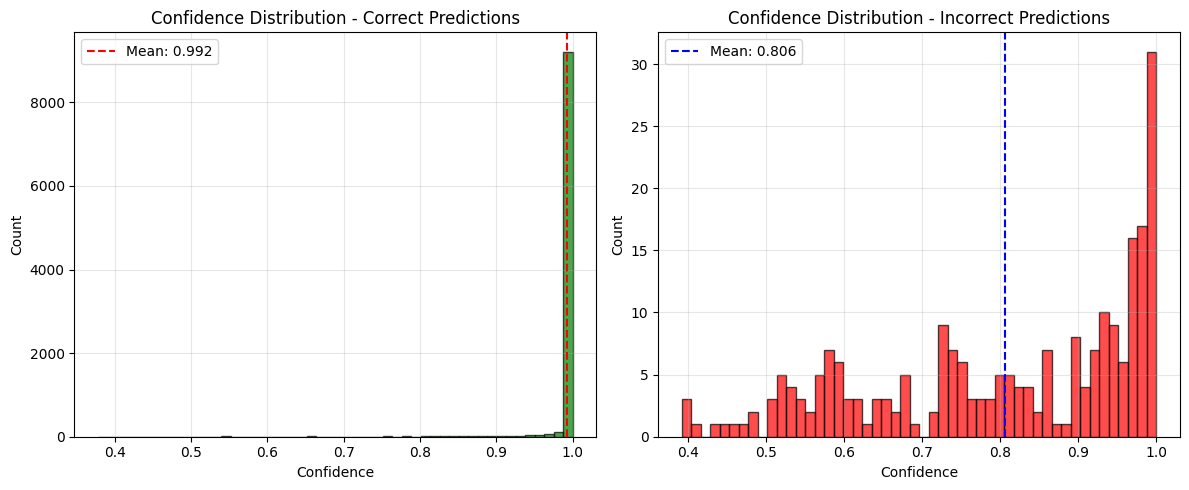


Insights:
- Correct predictions typically have higher confidence
- Some incorrect predictions still have high confidence (overconfident mistakes!)
- Low confidence predictions might indicate ambiguous/difficult cases


In [12]:
# Get confidence for each prediction (max probability)
confidences = np.max(all_probabilities, axis=1)

# Separate confidences for correct and incorrect predictions
correct_mask = all_predictions == all_labels
correct_confidences = confidences[correct_mask]
incorrect_confidences = confidences[~correct_mask]

print(f"Average confidence (correct predictions): {correct_confidences.mean():.3f}")
print(f"Average confidence (incorrect predictions): {incorrect_confidences.mean():.3f}")

# Plot confidence distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution - Correct Predictions')
plt.axvline(correct_confidences.mean(), color='red', linestyle='--', 
            label=f'Mean: {correct_confidences.mean():.3f}')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(incorrect_confidences, bins=50, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution - Incorrect Predictions')
plt.axvline(incorrect_confidences.mean(), color='blue', linestyle='--',
            label=f'Mean: {incorrect_confidences.mean():.3f}')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInsights:")
print("- Correct predictions typically have higher confidence")
print("- Some incorrect predictions still have high confidence (overconfident mistakes!)")
print("- Low confidence predictions might indicate ambiguous/difficult cases")

## 11. Classification Report

Let's get a detailed per-class performance report.

In [13]:
# Generate classification report
report = classification_report(all_labels, all_predictions, 
                               target_names=[str(i) for i in range(10)])

print("Classification Report:")
print("=" * 70)
print(report)

print("\nMetrics explanation:")
print("- Precision: Of all predictions for a digit, how many were correct?")
print("- Recall: Of all actual instances of a digit, how many did we find?")
print("- F1-score: Harmonic mean of precision and recall")
print("- Support: Number of true instances for each digit")

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.97      0.99      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Metrics explanation:
- Precision: Of all predictions for a digit, how many were correct?
- Recall: Of all actual instances of a digit, how many did we find?
- F1-score: Harmonic mean of precision and recall
- Support:

## 12. Find Most Confident Mistakes

Let's look at cases where the model was very confident but wrong.

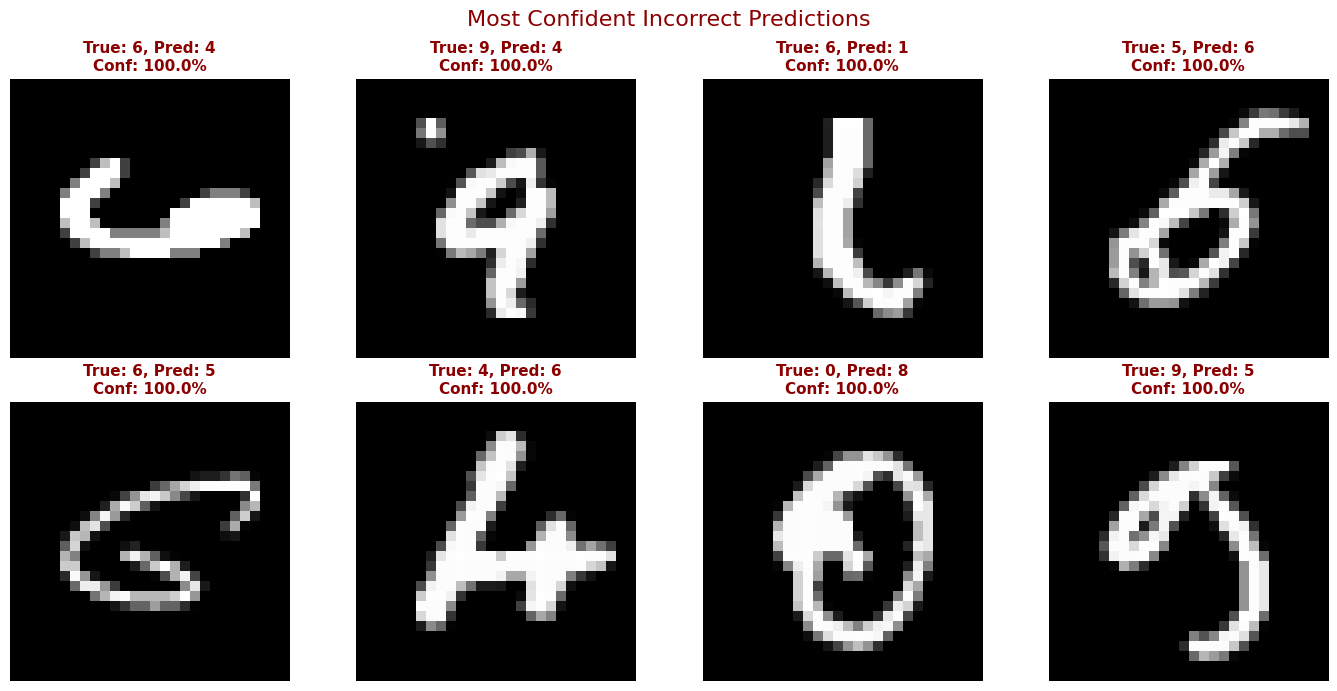

These are the model's most confident mistakes.
Often these are truly ambiguous cases or poorly written digits!


In [14]:
# Find incorrect predictions with highest confidence
incorrect_mask = all_predictions != all_labels
incorrect_idx = np.where(incorrect_mask)[0]
incorrect_conf = confidences[incorrect_mask]

# Sort by confidence
sorted_indices = incorrect_idx[np.argsort(incorrect_conf)[::-1]]

# Show top 8 most confident mistakes
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Most Confident Incorrect Predictions', fontsize=16, color='darkred')

for idx, ax in enumerate(axes.flat):
    if idx < min(8, len(sorted_indices)):
        img_idx = sorted_indices[idx]
        image, label = test_dataset[img_idx]
        prediction = all_predictions[img_idx]
        confidence = confidences[img_idx] * 100
        
        ax.imshow(image.squeeze().numpy(), cmap='gray')
        ax.set_title(f'True: {label}, Pred: {prediction}\nConf: {confidence:.1f}%', 
                     color='darkred', fontsize=11, fontweight='bold')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

print("These are the model's most confident mistakes.")
print("Often these are truly ambiguous cases or poorly written digits!")

## 13. Summary

Congratulations! You've completed Exercise 5. You now know:

✅ How to calculate overall and per-class accuracy

✅ How to create and interpret a confusion matrix

✅ How to identify common misclassifications

✅ How to analyze model confidence

✅ How to visualize correct and incorrect predictions

✅ How to find the model's most confident mistakes

✅ How to generate a detailed classification report

### Key Insights

From our evaluation, we learned:

1. **Overall Performance**: The model achieves ~97-98% accuracy on MNIST
2. **Per-Digit Performance**: Some digits are easier to recognize than others
3. **Common Confusions**: Certain digit pairs are commonly confused (e.g., 4/9, 3/8, 7/9)
4. **Confidence**: Correct predictions have higher average confidence
5. **Edge Cases**: Some mistakes are on genuinely ambiguous examples

### Why Evaluation Matters

- **Understanding Weaknesses**: Know where your model fails
- **Building Trust**: Verify the model works as expected
- **Identifying Improvements**: Find areas for enhancement
- **Real-world Deployment**: Understand confidence and reliability

### Next Steps

In Exercise 6, we'll use the model for inference - making predictions on new images!